<a href="https://colab.research.google.com/github/WHU-Peter/COMP6248-Deep-Learning/blob/master/DL_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([[0.1704, 0.3721],
        [0.1573, 0.6096],
        [0.2567, 0.7991]], dtype=torch.float64, requires_grad=True) tensor([[-22.3968,  11.0236],
        [  7.6691,  -1.8403],
        [-13.5005,   6.9014]], dtype=torch.float64, requires_grad=True)
tensor(0.1535, dtype=torch.float64, grad_fn=<MseLossBackward>)


Text(0.5, 1.0, 'Gradient by AD Framework')

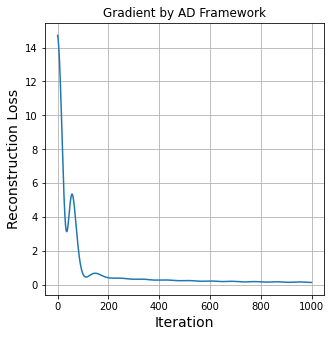

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.optim as optim

def gd_factorise_ad(A:torch.Tensor, rank:int, num_epochs=1000, lr=0.01):
  U_tensor = torch.rand(A.shape[0], rank, dtype=torch.double, requires_grad=True)
  V_tensor = torch.rand(A.shape[1], rank, dtype=torch.double, requires_grad=True)
  error = np.zeros(num_epochs)
  for n in range(num_epochs):
    L = torch.nn.functional.mse_loss(torch.mm(U_tensor, V_tensor.t()), A, reduction='sum')
    L.backward()
    U_tensor.data = U_tensor.data - lr * U_tensor.grad
    V_tensor.data = V_tensor.data - lr * V_tensor.grad
    U_tensor.grad.fill_(0)
    U_tensor.grad.fill_(0)
    error[n] = L
  return U_tensor,V_tensor,error

Aarray = np.array ([0.3374,0.6005,0.1735,3.3359,0.0492,1.8374,2.9407,0.5301,2.2620]).reshape(3,3)
A = torch.from_numpy(Aarray)
rank = 2
A_tensor = torch.tensor(A, dtype=torch.double, requires_grad=False)
U,V,ERROR = gd_factorise_ad(A_tensor, rank, lr=0.0005)
print (U,V)
print(torch.nn.functional.mse_loss(torch.mm(U, V.t()), A, reduction='sum'))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.plot(ERROR)
ax.grid(True)
ax.set_xlabel("Iteration", fontsize=14)
ax.set_ylabel("Reconstruction Loss", fontsize=14)
ax.set_title("Gradient by AD Framework",fontsize=12)

torch.Size([150, 2]) torch.Size([4, 2])
tensor(15.3808, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(15.2288, dtype=torch.float64)


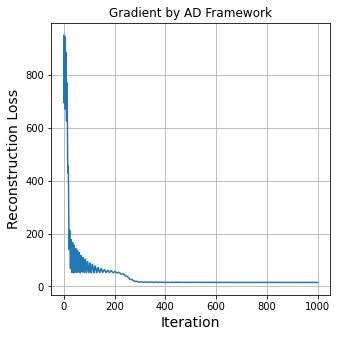

In [4]:
import pandas as pd
import torch.optim as optim

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None, encoding="utf-8")
data = torch.tensor(df.iloc[:, [0,1,2,3]].values)
data = data - data.mean(dim=0)

rank = 2
U,V,ERROR = gd_factorise_ad(data, rank, lr=0.003, num_epochs=1000)
print (U.shape, V.shape)
print(torch.nn.functional.mse_loss(torch.mm(U, V.t()), data, reduction='sum'))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.plot(ERROR)
ax.grid(True)
ax.set_xlabel("Iteration", fontsize=14)
ax.set_ylabel("Reconstruction Loss", fontsize=14)
ax.set_title("Gradient by AD Framework",fontsize=12)

U2, S2, V2 = torch.svd(data)
S2[2] = 0
S2[3] = 0
input = U2 @ torch.diag(S2) @ V2.t()
L = torch.nn.functional.mse_loss(input, data, reduction='sum')
print(L)

torch.Size([150, 4])
tensor([25.0899,  6.0079,  0.0000,  0.0000], dtype=torch.float64)
torch.Size([4, 4])
torch.Size([150, 4])
torch.Size([150, 2])
torch.Size([4, 2])


Text(0.5, 1.0, 'SVD')

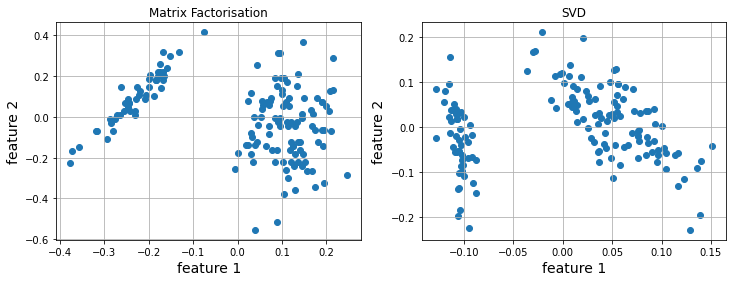

In [5]:
import math
# SVD
print(U2.shape)
print(S2)
print(V2.shape)
projection_PCA = U2
PCA_axe_1 = projection_PCA[:,0].detach().numpy()
PCA_axe_2 = projection_PCA[:,1].detach().numpy()

# Matrix Factorisation
print(data.shape)
print(U.shape)
print(V.shape)
MF_axe_1 = U[:,0].detach().numpy()
MF_axe_2 = U[:,1].detach().numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].scatter(MF_axe_1, MF_axe_2)
ax[0].grid(True)
ax[0].set_xlabel("feature 1", fontsize=14)
ax[0].set_ylabel("feature 2", fontsize=14)
ax[0].set_title("Matrix Factorisation",fontsize=12)
ax[1].scatter(PCA_axe_1, PCA_axe_2)
ax[1].grid(True)
ax[1].set_xlabel("feature 1", fontsize=14)
ax[1].set_ylabel("feature 2", fontsize=14)
ax[1].set_title("SVD",fontsize=12)

torch.Size([100, 4])
torch.Size([100])
0.03
0.04


Text(0.5, 1.0, 'Test Set')

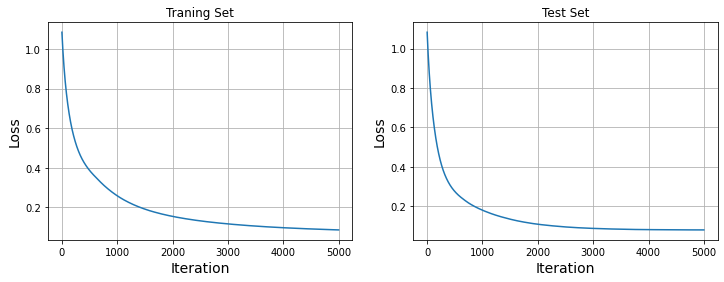

In [27]:
import pandas as pd
import torch.nn.functional as F

torch.set_default_tensor_type(torch.DoubleTensor)

class SimpleMLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleMLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size, bias=True) 
        self.fc2 = torch.nn.Linear(hidden_size, num_classes, bias=True)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        return out

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None) 
df = df.sample(frac=1) #shuffle
# add label indices column
mapping = {k: v for v, k in enumerate(df [4]. unique())} 
df[5] = df[4].map(mapping)
# normalise data
alldata = torch.tensor(df.iloc[:, [0,1,2,3]].values, dtype=torch.double) 
alldata = (alldata - alldata.mean(dim=0)) / alldata.var(dim=0)
# create datasets
targets_tr = torch.tensor(df.iloc[:100, 5].values, dtype=torch.long) 
targets_va = torch.tensor(df.iloc[100:, 5].values, dtype=torch.long)
data_tr = alldata [:100]
data_va = alldata [100:]
print(data_tr.shape)
print(targets_tr.shape)

num_epoches = 5000
error_tr = np.zeros(num_epoches)
error_va = np.zeros(num_epoches)
model = SimpleMLP(4, 12, 3)
optimizer=optim.SGD(model.parameters(),lr=0.01)

for n in range(num_epoches):
  optimizer.zero_grad()
  inputs = data_tr
  outputs = model(inputs)
  loss = torch.nn.functional.cross_entropy(outputs, targets_tr)
  loss.backward()
  optimizer.step()
  error_tr[n] = loss.data

  model.eval()
  outputs_va = model(data_va)
  loss_va = torch.nn.functional.cross_entropy(outputs_va, targets_va)
  error_va[n] = loss_va.data
  model.train()

model.eval()
logits = model(data_tr)
a = F.softmax(logits, dim=1)
a = a.argmax(dim=1)
print(np.nonzero(a - targets_tr).shape[0] / targets_tr.shape[0])

logits = model(data_va)
a = F.softmax(logits, dim=1)
a = a.argmax(dim=1)
print(np.nonzero(a - targets_va).shape[0] / targets_va.shape[0])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].plot(error_tr)
ax[0].grid(True)
ax[0].set_xlabel("Iteration", fontsize=14)
ax[0].set_ylabel("Loss", fontsize=14)
ax[0].set_title("Traning Set",fontsize=12)
ax[1].plot(error_va)
ax[1].grid(True)
ax[1].set_xlabel("Iteration", fontsize=14)
ax[1].set_ylabel("Loss", fontsize=14)
ax[1].set_title("Test Set",fontsize=12)